In [1]:
import os
import subprocess
import json

import numpy as np
import pandas as pd

from random import sample
from IPython.display import clear_output
from tqdm import tqdm

import torch
from torch import nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchmetrics.functional import accuracy

from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

os.environ["TOKENIZERS_PARALLELISM"] = (
    "false"  # безопасный способ избежать лишних предупреждений и проблем с многопоточностью при токенизации.
)
import warnings
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
PATH_TO_DATA = "./TERRa/"
train_path = PATH_TO_DATA + "train.jsonl"
val_path = PATH_TO_DATA + "val.jsonl"

In [5]:
with open(train_path, encoding='utf-8') as f:
    train = pd.DataFrame(json.loads(line) for line in f)
with open(val_path, encoding='utf-8') as f:
    val = pd.DataFrame(json.loads(line) for line in f)

In [6]:
train['label'] = train['label'].replace("entailment", 1)
train['label'] = train['label'].replace("not_entailment", 0)
val['label'] = val['label'].replace("entailment", 1)
val['label'] = val['label'].replace("not_entailment", 0)

In [7]:
train.to_json(path_or_buf=PATH_TO_DATA + "train_new.jsonl", orient="records", force_ascii=False)
val.to_json(path_or_buf=PATH_TO_DATA + "val_new.jsonl", orient="records", force_ascii=False)

In [8]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files=PATH_TO_DATA + "train_new.jsonl", split="train")
valid_dataset = load_dataset('json', data_files=PATH_TO_DATA + "val_new.jsonl", split="train")

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [9]:
len(train_dataset) , len(valid_dataset)

(2616, 307)

In [10]:
model_name = "Qwen/Qwen3-Embedding-0.6B"

# Initializing the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

1

In [11]:
class Model(nn.Module):
    def __init__(self, tokenizer, num_classes=2):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_classes
        )
        self.model.resize_token_embeddings(len(tokenizer))
        self.config = self.model.config

    def forward(
        self, input_ids=None, attention_mask=None, inputs_embeds=None, *args, **kwargs
    ):
        out = self.model.model(
            input_ids=input_ids,
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
        ).last_hidden_state

        lens = attention_mask.sum(-1).cpu() - 1
        out = out[torch.arange(len(lens)), lens.to(torch.long)]

        return self.model.score(out)

        @property
        def device(self):
            return next(self.model.parameters()).device

In [14]:
batch_size = 24

In [15]:
train_loader = DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=8
)
valid_loader = DataLoader(
    valid_dataset, shuffle=False, batch_size=batch_size, pin_memory=True, num_workers=8
)

In [16]:
print("not_entailment / entailment")

classes = [t["label"] for t in train_dataset]
print(f"Train: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

classes = [t["label"] for t in valid_dataset]
print(f"Valid: {1 - np.mean(classes):0.3f} {np.mean(classes):0.3f}")

not_entailment / entailment
Train: 0.481 0.519
Valid: 0.502 0.498


In [17]:
def training_loop_fn(
    model, opt, total_num_iters, eval_freq, train_loader, valid_loader
):
    train_loss_history, eval_loss_history = [], []
    train_acc_history, eval_acc_history = [], []
    global_step = 0

    criterion = torch.nn.CrossEntropyLoss()
    model.train()

    while True:
        for batch in tqdm(train_loader):
            tokenized = tokenizer(batch["premise"], batch["hypothesis"], padding=True, return_tensors="pt")
            for k, v in tokenized.items():
                tokenized[k] = v.to(device)
                
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(
                    tokenized["input_ids"],
                    tokenized["attention_mask"],
                    return_dict=False,
                )
                targets = batch["label"].to(device)
                loss = criterion(logits, targets)

            opt.zero_grad()
            loss.backward()
            opt.step()

            preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
            acc = accuracy(preds, targets, "binary")

            train_loss_history.append((global_step, loss.item()))
            train_acc_history.append((global_step, acc.item()))

            if global_step % eval_freq == 0:
                val_loss, val_acc = evaluate(model, valid_loader)
                eval_loss_history.append((global_step, val_loss))
                eval_acc_history.append((global_step, val_acc))
                model.train()

            if global_step % 23 == 0:                
                clear_output(True)
                plt.figure(figsize=(15, 5))

                plt.subplot(121)
                plt.plot(*zip(*train_loss_history), alpha=0.5, label='train_loss')
                if len(eval_loss_history):
                    plt.plot(*zip(*eval_loss_history), color='red', label='eval_loss')
                plt.legend()

                plt.subplot(122)
                plt.plot(*zip(*train_acc_history), alpha=0.5, label='train_acc')
                if len(eval_acc_history):
                    plt.plot(*zip(*eval_acc_history), color='red', label='eval_acc')
                plt.legend()
                plt.show()

                print(f"global_step:{global_step}")

            global_step += 1
            if global_step >= total_num_iters:
                break
        else:
            continue
        break

@torch.no_grad()
def evaluate(model, dataloader):
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    loss_epoch = 0.
    num_epoch = 0
    preds_list = []
    targets_list = []

    for eval_batch in dataloader:
        tokenized = tokenizer(eval_batch["premise"], eval_batch["hypothesis"], padding=True, return_tensors="pt")
        for k, v in tokenized.items():
            tokenized[k] = v.to(device)

        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(tokenized["input_ids"], tokenized["attention_mask"], return_dict=False)

        loss = criterion(logits, eval_batch["label"].to(device))
        num = logits.shape[0]

        loss_epoch += loss.item() * num
        num_epoch += num

        preds = torch.nn.functional.softmax(logits, dim=-1)[:, 1]
        targets_list += eval_batch["label"].tolist()
        preds_list += preds.tolist()

    acc = accuracy(
        torch.tensor(preds_list).to(device), 
        torch.tensor(targets_list).to(device), 
        "binary"
    )

    return loss_epoch / num_epoch, acc.item()

        

In [18]:
chkpt = torch.load('head_LP.pt')
chkpt.keys()

odict_keys(['weight'])

In [19]:
chkpt

OrderedDict([('weight',
              tensor([[-0.0363,  0.0381, -0.0239,  ..., -0.0197, -0.0053,  0.0151],
                      [ 0.0129, -0.0109, -0.0020,  ..., -0.0029, -0.0153, -0.0032]],
                     device='cuda:0'))])

In [20]:
num_classes = 2
model = Model(tokenizer, num_classes).to(device)
model.model.score.load_state_dict(chkpt)
optimizer = AdamW(model.parameters(), lr=2e-6)

Some weights of Qwen3ForSequenceClassification were not initialized from the model checkpoint at Qwen/Qwen3-Embedding-0.6B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


In [23]:
model

Model(
  (model): Qwen3ForSequenceClassification(
    (model): Qwen3Model(
      (embed_tokens): Embedding(151670, 1024)
      (layers): ModuleList(
        (0-27): 28 x Qwen3DecoderLayer(
          (self_attn): Qwen3Attention(
            (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
            (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
            (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
          )
          (mlp): Qwen3MLP(
            (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
            (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
            (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qw

In [21]:
count_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {count_parameters:,}")

Number of trainable parameters: 595,779,584


In [22]:
param_size = count_parameters * 4 
print(f"Estimated model size in memory: {param_size / 1024**3:.2f} GB")

Estimated model size in memory: 2.22 GB


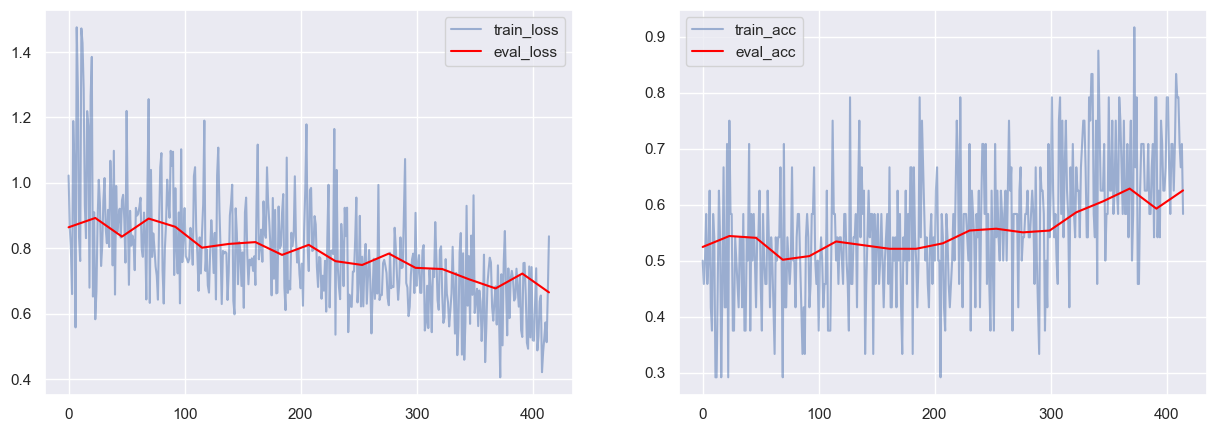

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 88/109 [1:08:09<27:38, 78.95s/it]

global_step:414


  0%|                                                                                                                                                                                                     | 0/109 [01:07<?, ?it/s]

CPU times: total: 4h 11min 18s
Wall time: 6h 13min 50s


In [24]:
%%time
training_loop_fn(model, optimizer, 437, 23, train_loader, valid_loader)

In [25]:
val_loss, val_acc = evaluate(model, valid_loader)
print(f'val loss: {val_loss}')
print(f'val acc: {val_acc}')

val loss: 0.6760389098127035
val acc: 0.6058632135391235


In [26]:
torch.save(model.model.score.state_dict(), "head_LP_FT.pt")

In [27]:
torch.save(model.state_dict(), "full_LP_FT.pt")